## Augmentarion, pure `EfficientNetV2S` train

In [1]:
import os
import pickle

import tensorflow as tf
# import tensorflow_models as tfm

from tensorflow.keras import Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.data import Dataset
from tensorflow.keras import optimizers
from tensorflow.keras import losses, metrics
from tensorflow.keras import callbacks

2025-07-04 00:59:23.269878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751558363.287245  862086 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751558363.292510  862086 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751558363.308731  862086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751558363.308753  862086 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751558363.308754  862086 computation_placer.cc:177] computation placer alr

In [2]:
AUTOTUNE = tf.data.AUTOTUNE  # cache and prefetch for augmenting performance
dataset_path = './datasets/'
butterfly_test = Dataset.load(os.path.join(dataset_path, 'butterfly_test')).cache().prefetch(buffer_size=AUTOTUNE)
butterfly_train = Dataset.load(os.path.join(dataset_path, 'butterfly_train')).cache().prefetch(buffer_size=AUTOTUNE)
butterfly_val = Dataset.load(os.path.join(dataset_path, 'butterfly_val'))

I0000 00:00:1751558369.082693  862086 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2b:00.0, compute capability: 8.9


In [3]:
with open('./datasets/class_weights.pkl', 'rb') as f:
    class_weights = {k : v for k, v in enumerate(pickle.load(f))}

with open('./datasets/index_to_label.pkl', 'rb') as f:
    index_to_label = pickle.load(f)
    n_classes = len(set(index_to_label.keys()))

def to_one_hot(x, y):
    y = tf.one_hot(y, n_classes)
    return x, tf.cast(y, tf.float32)

# for label-smoothing
butterfly_test = butterfly_test.map(to_one_hot,
                                    num_parallel_calls=AUTOTUNE)
butterfly_train = butterfly_train.map(to_one_hot,
                                      num_parallel_calls=AUTOTUNE)
butterfly_val = butterfly_val.map(to_one_hot,
                                  num_parallel_calls=AUTOTUNE)

In [4]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(
        height_factor=(-.2, .2),
        width_factor=(-.2, .2),
        #fill_mode='nearest',
        interpolation='bilinear',
    ),
    layers.RandomRotation(
        factor=.1,
        #fill_mode='nearest',
        interpolation='bilinear',
    ),
  ],
  name = 'data_augmentation'
)

2025-07-04 00:59:32.275473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-07-04 00:59:32.361501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


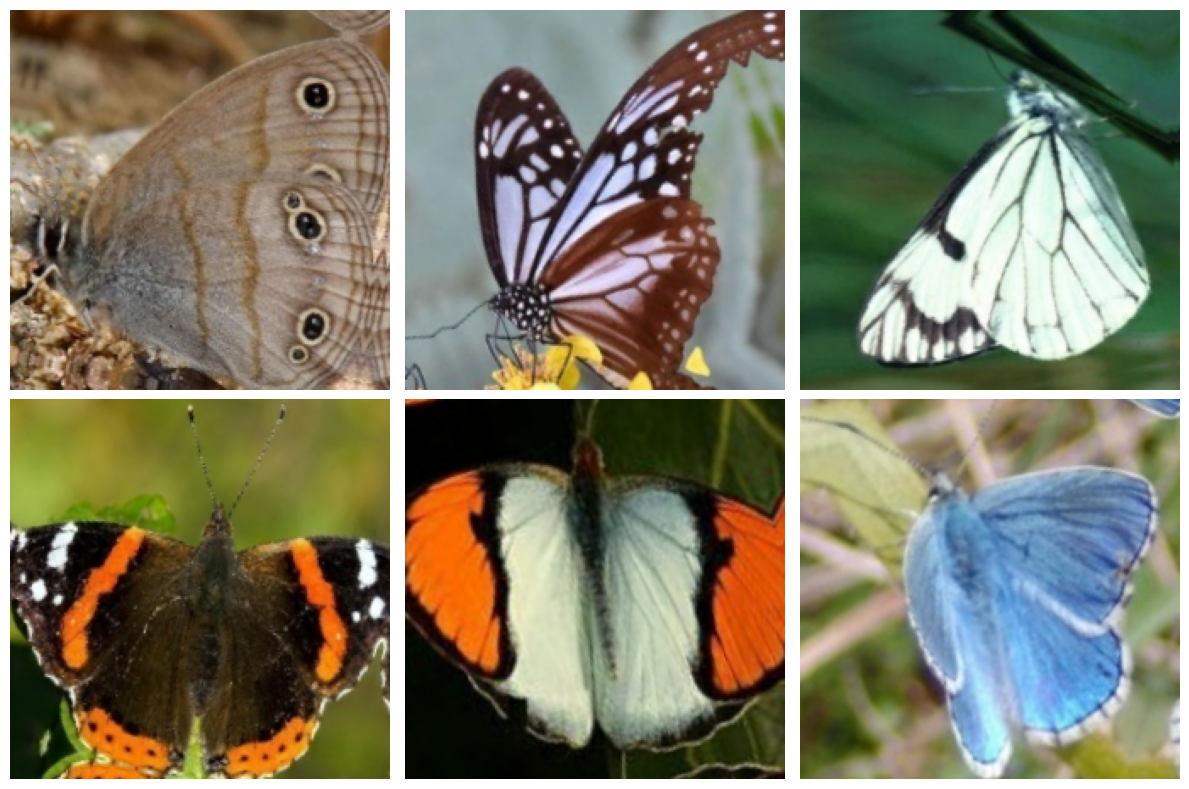

In [5]:
from matplotlib import pyplot as plt
import numpy as np

batch_images, batch_labels = np.array([]), np.array([])

for images, labels in butterfly_train.take(1):  # take(1) as in a single batch (32 images), single loop!
    batch_images = images
    batch_labels = labels

aug_imgs = data_augmentation(batch_images)

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(aug_imgs[i].numpy().astype("uint8"))
    # plt.title(f"Label: {batch_labels[i].numpy()} - {index_to_label[batch_labels[i].numpy()]}")  # only for integer labeling
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
v2s_base = EfficientNetV2S(
    include_top=False,
    weights='imagenet',  # W, b initialization (FIXED!!!, DO NOT USE RANDOM INIT WHEN FINE TUNING MODELS)
    input_shape=(260, 260, 3),
    pooling='avg',  # 2D tensor output
    include_preprocessing=True,  # inputs to be float tensors of pixels with values in the [0, 255] range to -> [1, -1]
)

v2s_base.trainable = False  # Freeze base model

# =============== MODEL ===============
inp = layers.Input(shape=(224, 224, 3), 
                   name='input')
x = data_augmentation(inp)
x = layers.Resizing(260, 260, 
                    interpolation='bilinear',
                    name='resize')(x)
x = v2s_base(x, training=False)
x = layers.Dropout(0.5)(x)
out = layers.Dense(75, 
                   activation='softmax', 
                   name='output')(x)
# =============== MODEL ===============

model = Model(inputs=inp, outputs=out, name='EfficientNetV2S_augementation')

model.summary()

Model: "EfficientNetV2S_augementation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,427,435 (77.92 MB)

 Trainable params: 96,075 (375.29 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [11]:
callbacks_list = [
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-6,
        verbose=1,
    ),
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1,
    )
]

# https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
# def scce_with_label_smoothing(y, y_hat):
#     y = tf.one_hot(tf.cast(y, tf.int32), n_classes)
#     return losses.categorical_crossentropy(y, y_hat, label_smoothing = 0.1)

In [12]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=.005),
    loss=losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.1,
    ),
    metrics=['accuracy'],
)

In [13]:
history = model.fit(
    butterfly_train,
    validation_data=butterfly_val,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks_list,
)

Epoch 1/50


I0000 00:00:1751558447.260648  862171 cuda_dnn.cc:529] Loaded cuDNN version 90300


130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - accuracy: 0.2859 - loss: 3.3375 - val_accuracy: 0.7263 - val_loss: 1.7932 - learning_rate: 0.0050
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.7007 - loss: 1.7842 - val_accuracy: 0.7757 - val_loss: 1.5284 - learning_rate: 0.0050
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.7530 - loss: 1.6236 - val_accuracy: 0.8230 - val_loss: 1.4118 - learning_rate: 0.0050
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.7961 - loss: 1.5168 - val_accuracy: 0.8333 - val_loss: 1.4032 - learning_rate: 0.0050
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.8155 - loss: 1.4821 - val_accuracy: 0.8560 - val_loss: 1.3559 - learning_rate: 0.0050
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.8115 - loss: 1.4794 - val_accuracy: 0.8416 - val_loss: 1.3578 - learning_rate: 0.0050
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.8185 - loss: 1.474

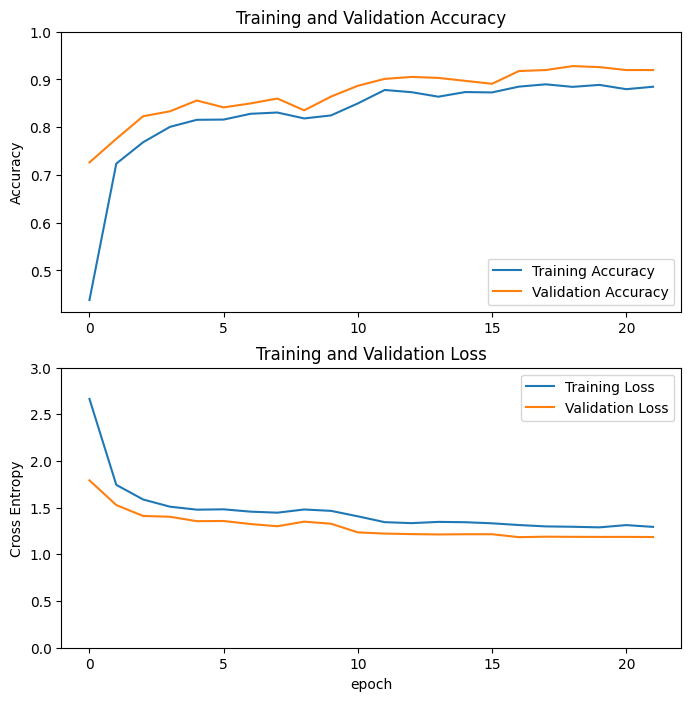

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3])
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [16]:
v2s_base.trainable = True
print("Number of layers in the base model: ", len(v2s_base.layers))

Number of layers in the base model:  514


In [17]:
fine_tune_at = 300
for layer in v2s_base.layers[:fine_tune_at]:
  layer.trainable = False

len(model.trainable_variables)

187

In [18]:
# Increase res, Progressive learning
resize = model.get_layer('resize')
resize.target_height = resize.target_width = 260

model.compile(
    optimizer=optimizers.Adam(learning_rate=.0001),
    loss=losses.CategoricalCrossentropy(
        from_logits=False,
        label_smoothing=0.1,
    ),
    metrics=['accuracy'],
)

model.summary()

Model: "EfficientNetV2S_augementation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize (Resizing)               │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 75)             │        96,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,427,435 (77.92 MB)

 Trainable params: 14,497,995 (55.31 MB)

 Non-trainable params: 5,929,440 (22.62 MB)

In [19]:
fine_tune_history = model.fit(
    butterfly_train,
    validation_data=butterfly_val,
    epochs=len(history.epoch) + 30,
    initial_epoch=len(history.epoch),
    class_weight=class_weights,
    callbacks=callbacks_list,
)

Epoch 23/52


E0000 00:00:1751558844.303134  862086 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/EfficientNetV2S_augementation_1/efficientnetv2-s_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.7672 - loss: 1.6281 - val_accuracy: 0.9074 - val_loss: 1.2125 - learning_rate: 1.0000e-04
Epoch 24/52
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9234 - loss: 1.1882 - val_accuracy: 0.9218 - val_loss: 1.1369 - learning_rate: 1.0000e-04
Epoch 25/52
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.9571 - loss: 1.0821 - val_accuracy: 0.9300 - val_loss: 1.0921 - learning_rate: 1.0000e-04
Epoch 26/52
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.9714 - loss: 1.0245 - val_accuracy: 0.9259 - val_loss: 1.0760 - learning_rate: 1.0000e-04
Epoch 27/52
130/130 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.9760 - loss: 0.9819 - val_accuracy: 0.9280 - val_loss: 1.0636 - learning_rate: 1.0000e-04
Epoch 28/52
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - accuracy: 0.9872 - loss: 0.9530 - val_accuracy: 0.9383 - val_loss: 1.0542 - learning_rate: 1.0000e-04
Epoch 29/52
130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/s

In [20]:
all_acc = acc + fine_tune_history.history['accuracy']
all_val_acc = val_acc + fine_tune_history.history['val_accuracy']

all_loss = loss + fine_tune_history.history['loss']
all_val_loss = val_loss + fine_tune_history.history['val_loss']

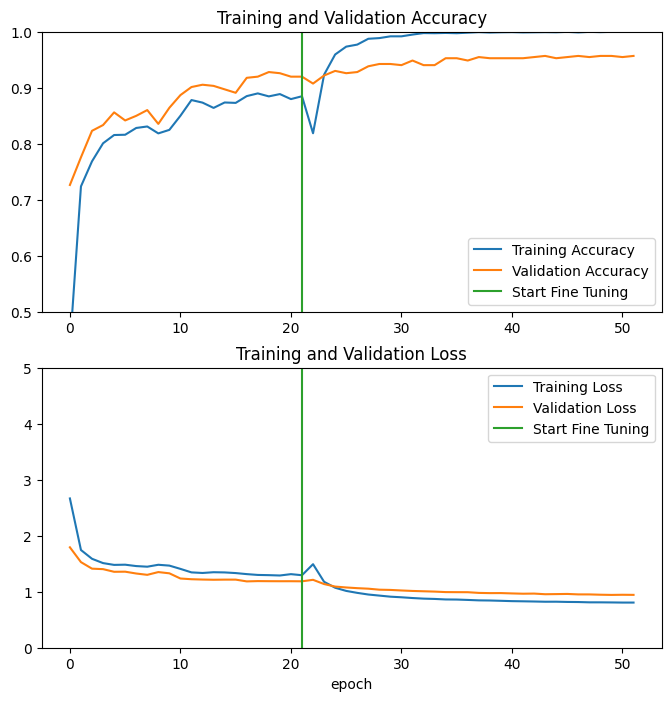

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(all_acc, label='Training Accuracy')
plt.plot(all_val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(all_loss, label='Training Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([len(history.epoch)-1,len(history.epoch)-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [22]:
results = model.evaluate(butterfly_test)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9599 - loss: 0.9465
Test loss: 0.9719443917274475
Test accuracy: 0.9553264379501343
